Github link: https://github.com/genom10/Sensors2023/tree/master/HW5

# Task 5.1

In [18]:
!pip install sklearn
!pip install open3d

In [19]:
import scipy as sc
from PIL import Image
from open3d.web_visualizer import draw

## Generate noisy data

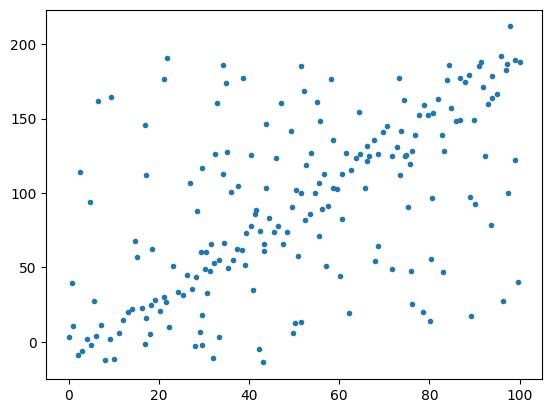

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    try:
        return x*2-10 + np.random.normal(scale=10, size=len(x))
    except:
        return x*2-10 + np.random.normal(scale=10)

X = np.linspace(0, 100, 100)
Y = f(X)

noizedX = np.append(X, np.random.uniform(low=0, high=100, size = 100))
noizedY = np.append(Y, np.random.uniform(low=f(0), high=f(100), size = 100))

plt.plot(noizedX, noizedY, '.')

## use RANSAC from `sklearn.linear_models`

In [22]:
x = noizedX.reshape(-1, 1)
y = noizedY.reshape(-1, 1)

In [23]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [29]:
line_x_ransac = np.array([x.min(), x.max()])
line_y_ransac = ransac.predict(line_x_ransac.reshape(-1, 1)).T
line_ransac = np.vstack((line_x_ransac, line_y_ransac))
print(line_ransac)

[[  0.         100.        ]
 [ -9.4214118  191.53966557]]


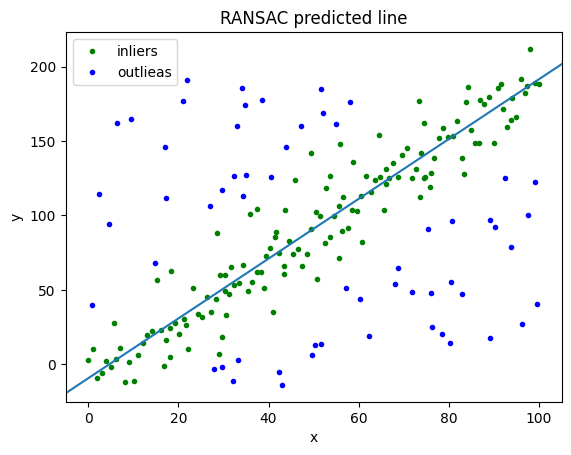

In [30]:
plt.title('RANSAC predicted line')
plt.plot(x[inlier_mask], y[inlier_mask], 'og', markersize=3, label='inliers')
plt.plot(x[outlier_mask], y[outlier_mask], 'ob', markersize=3, label='outlieas')
plt.axline(*(line_ransac.T))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Task 5.2

## Load cloud of points

Reference model: https://github.com/genom10/Sensors2023/tree/master/HW5/ObjectRecognition.blend

Point cloud: https://github.com/genom10/Sensors2023/tree/master/HW5/Suzan.ply

In [83]:
import open3d as o3d
pcd = o3d.io.read_point_cloud('Suzan.ply')
o3d.visualization.draw_geometries([pcd])

In case `object3d` is not installed:

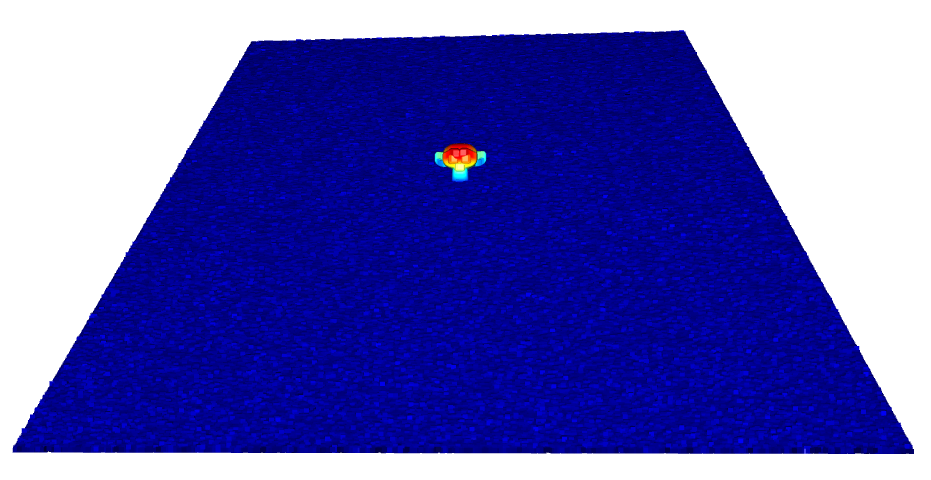

In [84]:
cloud = np.asarray(pcd.points)
cloud.shape

(294827, 3)

## Detect floor

In [85]:
x, y = cloud[:, :2], cloud[:, 2]
print(x.shape)
print(y.shape)

(294827, 2)
(294827,)


In [95]:
ransac = RANSACRegressor(residual_threshold=0.2) # higher number -> more points regarded as part of he floor
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
ransac.score(x, y)

-0.09330398233602222

In [87]:
inliers_color = np.array([0, 1, 0.2])
outliers_color = np.array([0.1, 0, 1])

pointColor = np.zeros_like(cloud)
pointColor[inlier_mask, :] = inliers_color
pointColor[outlier_mask, :] = outliers_color

## Visualize classification of the points

In [88]:
pc_result = o3d.geometry.PointCloud()
pc_result.points = o3d.utility.Vector3dVector(cloud)
pc_result.colors = o3d.utility.Vector3dVector(pointColor)
o3d.visualization.draw_geometries([pc_result])

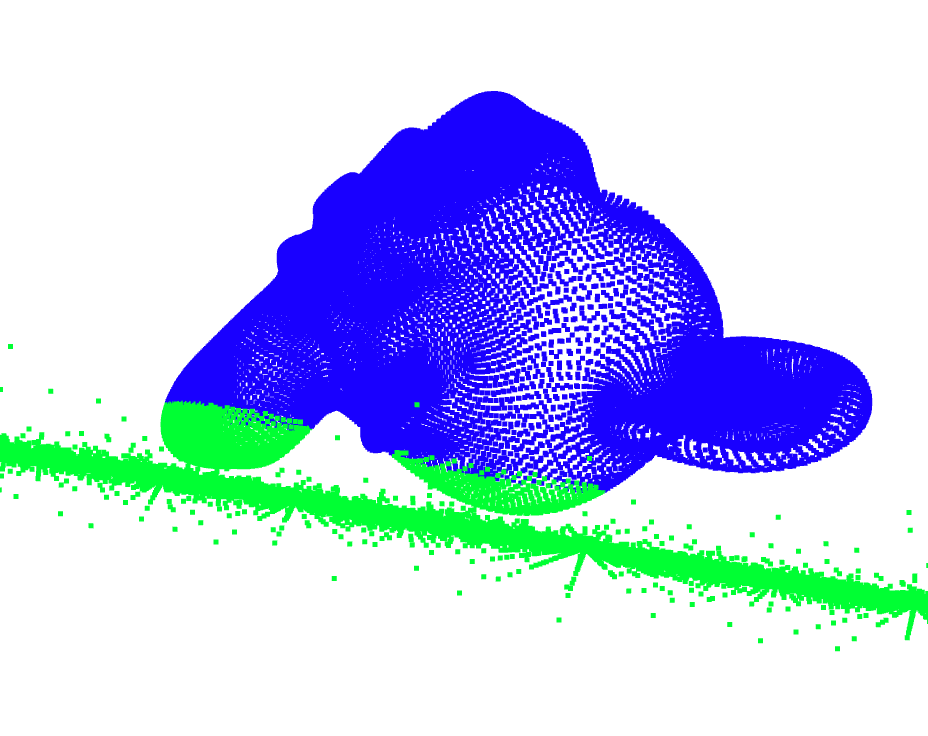

## Color-code object by its distance to the floor plane 

Now, let me not only calculate a minimal distance to the object:

In [89]:
obj = np.hstack(([x[outlier_mask], y[outlier_mask].reshape(-1, 1)]))
obj.shape

(29922, 3)

In [96]:
print(obj)
distances = ransac.predict(x[outlier_mask])
min_dist = distances.min()
max_dist = distances.max()

print(min_dist)
print(max_dist)

[[ 0.47888169 -0.35663345  0.2470662 ]
 [ 0.47714174 -0.36384735  0.23736972]
 [ 0.48358229 -0.35834619  0.23189092]
 ...
 [-0.68038887  0.22927949 -0.56934977]
 [-0.65964133  0.23103347 -0.56771386]
 [-0.63897783  0.23176916 -0.56646132]]
-0.9505655968032342
-0.9505565727549763


but also colour the object based on the distance to it:

In [91]:
norm_distances = (distances - min_dist) / (max_dist - min_dist)
obj_heatmap = np.array([1 - norm_distances, np.zeros_like(norm_distances), norm_distances]).T
obj_heatmap.shape

(29922, 3)

Running a visualisation for the last time:

In [92]:
pc_heatmap = o3d.geometry.PointCloud()
pc_heatmap.points = o3d.utility.Vector3dVector(obj)
pc_heatmap.colors = o3d.utility.Vector3dVector(obj_heatmap)
o3d.visualization.draw_geometries([pc_heatmap])

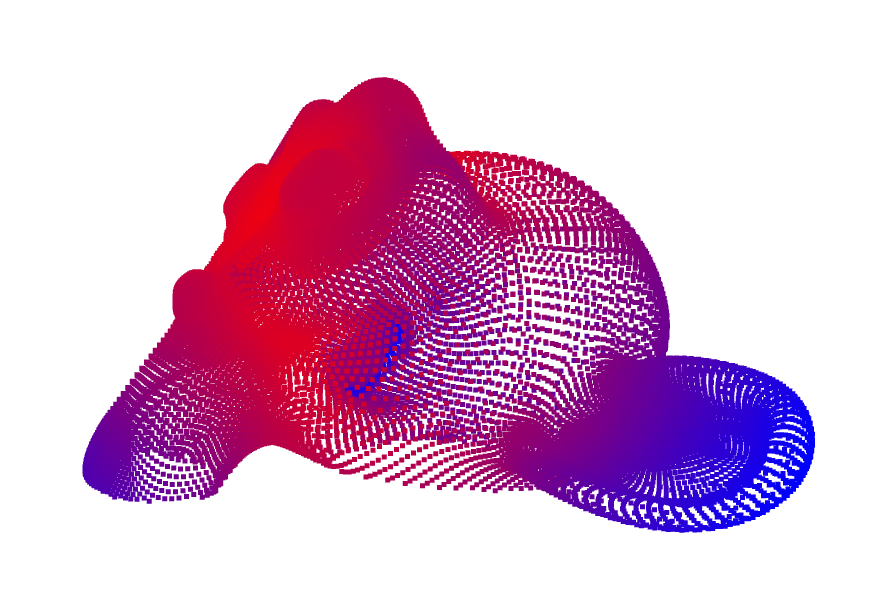